# **TensorFlow**

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

# Dataset

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
val_size = 5000
train_size = train_images.shape[0] - val_size

# Set seed for reproducibility
np.random.seed(42)

# Shuffle and split
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

train_idx = indices[:train_size]
val_idx = indices[train_size:]

train_X, train_y = train_images[train_idx], train_labels[train_idx]
val_X, val_y = train_images[val_idx], train_labels[val_idx]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Preprocessing

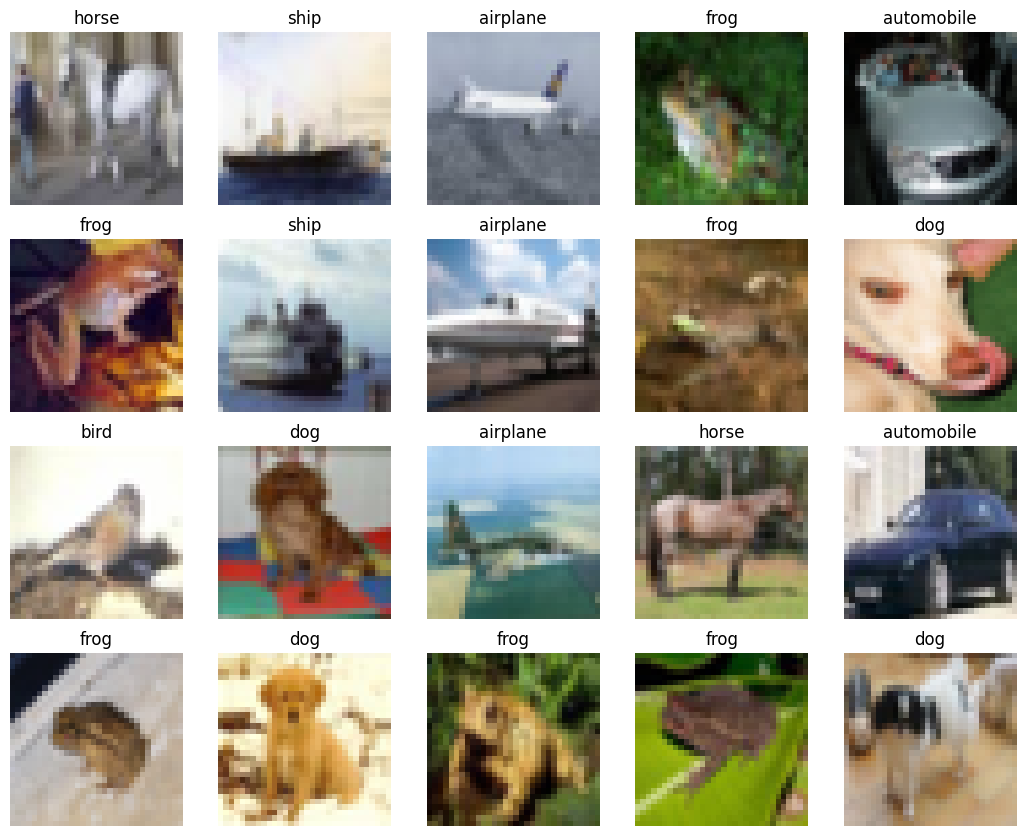

In [ ]:
plt.figure(figsize=(13,13))
for i,(image,label) in enumerate(train_ds.take(20)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

In [ ]:
def process_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (32, 32))
    image = tf.image.per_image_standardization(image)
    return image, label

# Data

In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()

print('Train size:', train_ds_size)
print('Validation size:', val_ds_size)
print('Test size:', test_ds_size)

Train size: 45000
Validation size: 5000
Test size: 10000


In [ ]:
train_ds = (train_ds
            .shuffle(buffer_size=train_size)
            .map(process_image)
            .batch(batch_size=2)
            .prefetch(tf.data.AUTOTUNE))
val_ds = (val_ds
          .map(process_image)
          .batch(batch_size=2)
          .prefetch(tf.data.AUTOTUNE))
test_ds = (test_ds
           .map(process_image)
           .batch(batch_size=2)
           .prefetch(tf.data.AUTOTUNE))

# Model

In [ ]:
model = keras.models.Sequential([
    # Layer 1
    keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32, 32, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Layer 2
    keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Layer 3
    keras.layers.Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),

    # Layer 4
    keras.layers.Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),

    # Layer 5
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Fully Connected
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),  # Reduced FC for Colab stability
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),

    # Output
    keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training and Validation

In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 192)           │         221,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 192)           │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 192)           │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,5

 Total params: 2,170,250 (8.28 MB)

 Trainable params: 2,168,842 (8.27 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data = val_ds,
    validation_freq = 1
)

Epoch 1/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 111s 5ms/step - accuracy: 0.1552 - loss: 2.5243 - val_accuracy: 0.4060 - val_loss: 1.6043
Epoch 2/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - accuracy: 0.3854 - loss: 1.6738 - val_accuracy: 0.5290 - val_loss: 1.3694
Epoch 3/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 138s 4ms/step - accuracy: 0.4824 - loss: 1.4643 - val_accuracy: 0.5314 - val_loss: 1.5590
Epoch 4/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.5326 - loss: 1.3580 - val_accuracy: 0.5930 - val_loss: 1.2624
Epoch 5/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - accuracy: 0.5626 - loss: 1.2867 - val_accuracy: 0.5556 - val_loss: 48.5437
Epoch 6/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 140s 4ms/step - accuracy: 0.5872 - loss: 1.2224 - val_accuracy: 0.5758 - val_loss: 124.5567
Epoch 7/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 144s 5ms/step - accuracy: 0.6016 - loss: 1.1854 - val_accuracy: 0.5946 - val_loss: 54.2434
Epoch 8/30
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 137s 4ms/step -

In [ ]:
model.history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

# Training and Validation Results

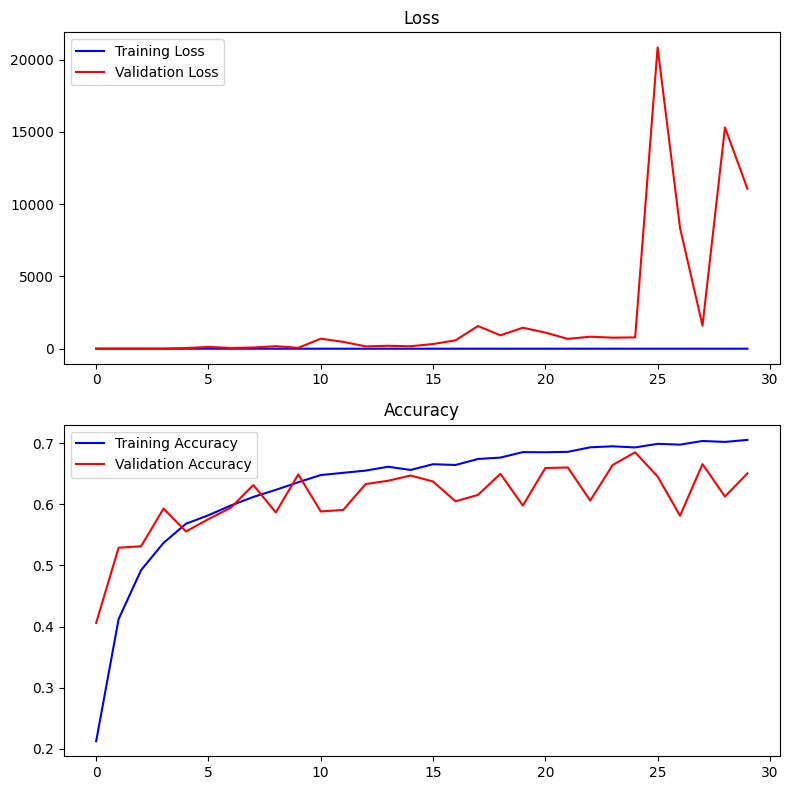

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(8, 8))

# Loss plot
ax[0].plot(model.history.history['loss'], color='b', label='Training Loss')
ax[0].plot(model.history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Accuracy plot
ax[1].plot(model.history.history['accuracy'], color='b', label='Training Accuracy')
ax[1].plot(model.history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

# Testing and Results

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6502 - loss: 11033.3164
Final Test Accuracy: 65.37%
